
### 1) Use python to programmatically download/read a 16-bit TIF micrograph with fluorescently labelled cell nuclei from the following location:
https://github.com/Shutterbug2109/Microscopic-Image-analysis/raw/main/Sample.tif
### Once loaded display the images, scale them appropriately to ensure the cell nuclei are visible.
NB: Make sure to import all the necessary libraries allowing you to load raw TIFs.

In [1]:
from tifffile import imread
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cv2 
from google.colab.patches import cv2_imshow
from google.colab import files
import skimage
from skimage import io, color,measure
from skimage.transform import rescale,resize,downscale_local_mean
from skimage.filters import sobel,gaussian
from skimage.io import imsave, imread, imshow
#uploaded = files.upload()
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%matplotlib inline
#Setting figuresize
plt.rcParams["figure.figsize"] = (10,10)

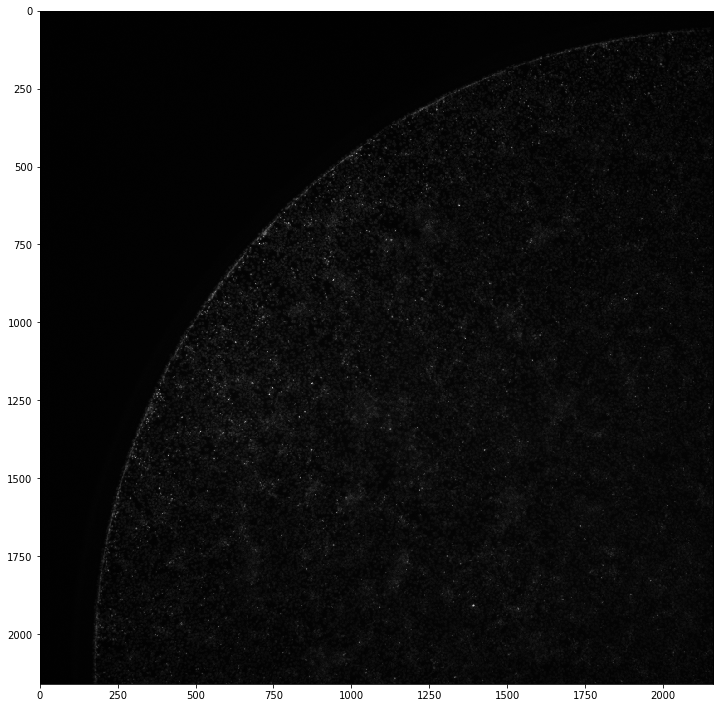

In [4]:
# skimage read the image as RGB while CV2 read as BGR
# url where the image is stored

img_url = 'https://github.com/Shutterbug2109/Microscopic-Image-analysis/raw/main/Sample.tif'
# load the image file 
img = imread(img_url)
# display the image
imshow(img)


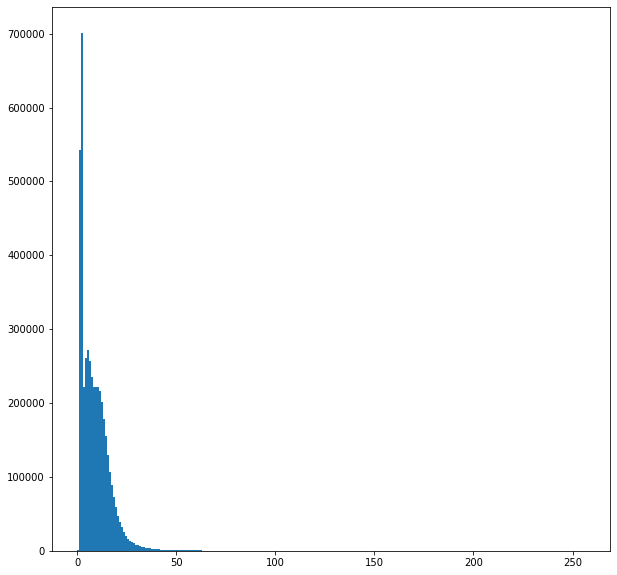

In [5]:
# plot a histogram showing the distribution of pixel values
plt.hist(img.ravel(),256,[0,256]); 
plt.show()

In [6]:
print('Image size is {} shaped as a {}*{} matrix'.format(img.size, img.shape[0], img.shape[1])) 
print('Maximum pixel value is {} while minimum pixel value is {}'.format(img.max(), img.min()))
print('Dimension of Image {}'.format(img.ndim))

Image size is 4665600 shaped as a 2160*2160 matrix
Maximum pixel value is 255 while minimum pixel value is 0
Dimension of Image 2


## 2) Use an arbitrary threshold value (defined manually) to convert nuclei from the grayscale image to a binary mask. Once done - display the mask and the raw image side-by-side.
Optional: find optimal threshold value automatically.

Threshold value is 10.0


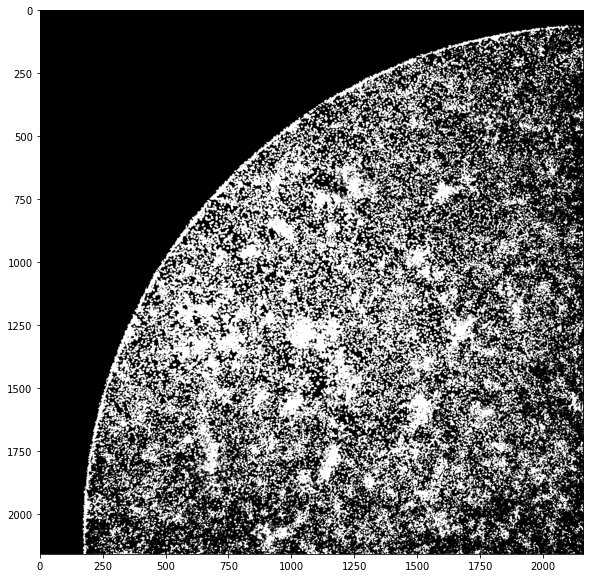

In [7]:
# Manual Thresholding
man_thresh, im_bw = cv2.threshold(img, 10, 255, cv2.THRESH_BINARY )
print(f'Threshold value is {man_thresh}')

fig, ax = plt.subplots()
plt.imshow(im_bw, cmap='gray')
cv2.imwrite('content/drive/My Drive/Colab Notebooks/Binarymask.png',im_bw)
plt.show()

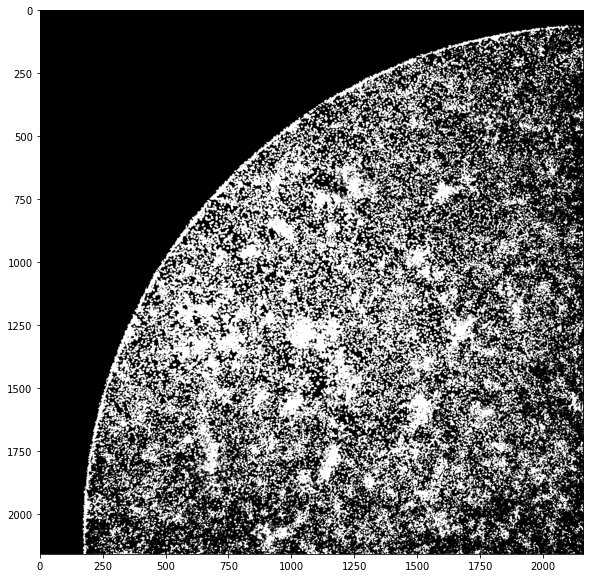

In [8]:
# create a binary mask with the threshold found by Otsu's method from Skimage
otsu_thresh = skimage.filters.threshold_otsu(img)
masked_img = img > otsu_thresh

fig, ax = plt.subplots()
plt.imshow(masked_img, cmap='gray')
plt.show()

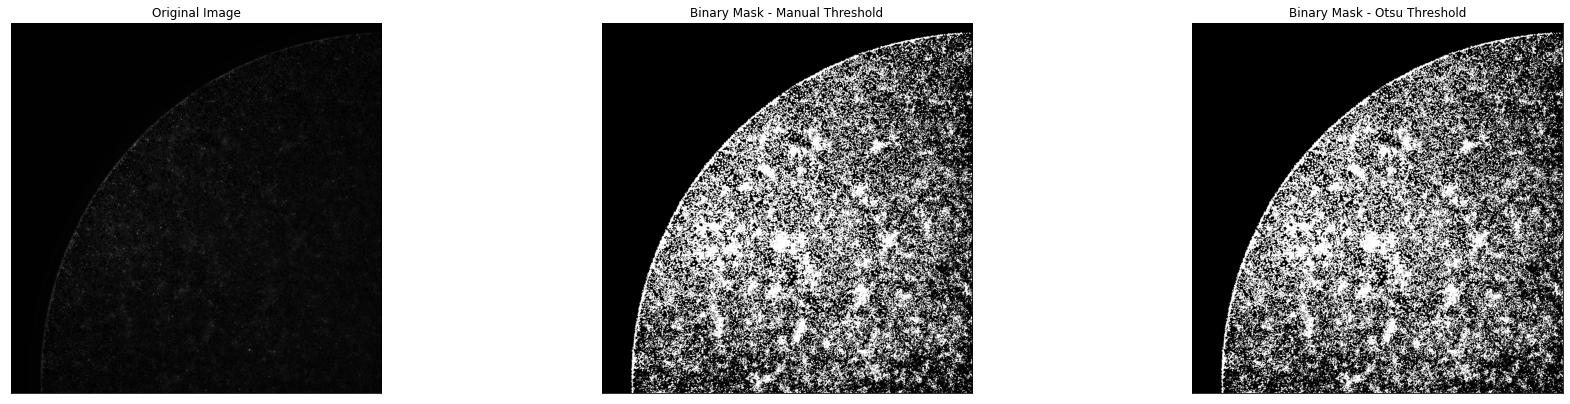

In [9]:
plt.rcParams["figure.figsize"] = (30,15)

# Display images side by side
plt.subplot(231), plt.imshow(img, cmap='gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])

plt.subplot(232), plt.imshow(im_bw, cmap='gray')
plt.title('Binary Mask - Manual Threshold'), plt.xticks([]), plt.yticks([])

plt.subplot(233), plt.imshow(masked_img, cmap='gray')
plt.title('Binary Mask - Otsu Threshold'), plt.xticks([]), plt.yticks([])

plt.show()

## 3) Measure and display the pixel area of each nucleus. Avoid thresholding artifacts, which differ significantly from the nuclei in certain aspects.

(Text(0.5, 1.0, 'Histogram'),
 ([], <a list of 0 Text major ticklabel objects>),
 ([], <a list of 0 Text major ticklabel objects>))

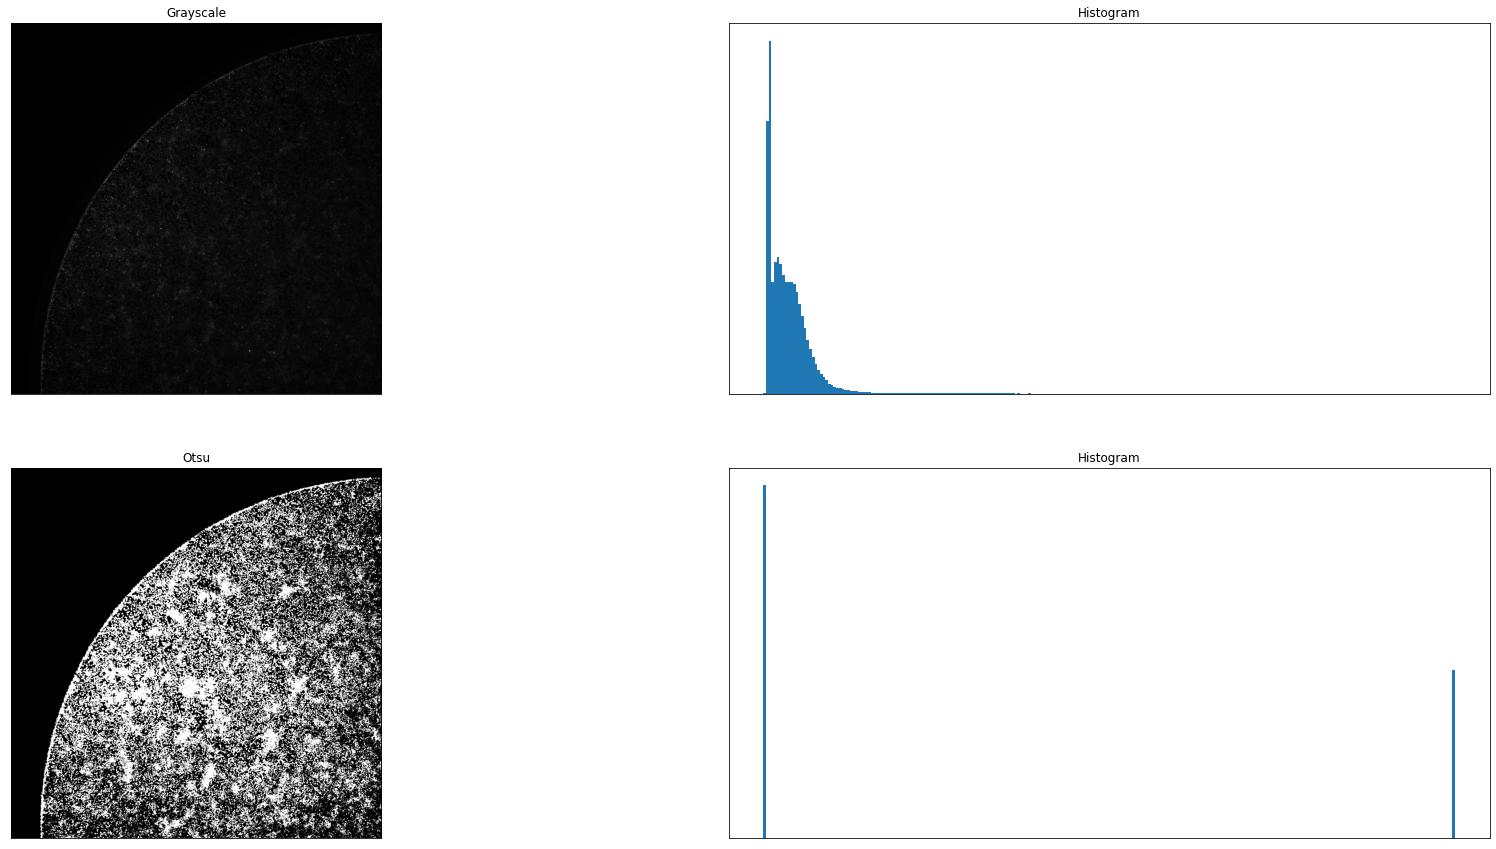

In [10]:

plt.rcParams["figure.figsize"] = (30,15)
# Threshold the image to binary using Otsu's method using cv2
ret, thresh = cv2.threshold(img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

plt.rcParams["figure.figsize"] = (30,15)
plt.subplot(221), plt.imshow(img, cmap='gray')
plt.title('Grayscale'), plt.xticks([]), plt.yticks([])

plt.subplot(222), plt.hist(img.ravel(),256)
plt.title('Histogram'), plt.xticks([]), plt.yticks([])

plt.subplot(223), plt.imshow(thresh, cmap='gray')
plt.title('Otsu'), plt.xticks([]), plt.yticks([])

plt.subplot(224), plt.hist(thresh.ravel(),256)
plt.title('Histogram'), plt.xticks([]), plt.yticks([])

In [11]:
# find number of pixels which were bright 
# this gives a rough idea of area occupied by the nucleus
num_white_after_threshold = np.sum(img>ret)
# calculate total image size
total_img_area = img.size
# find percent area occupied by the nucleus
percent_nucleus_area = (1.0 * num_white_after_threshold / total_img_area) * 100
print(f'Percent area occupied by the nucleus is {percent_nucleus_area}')

Percent area occupied by the nucleus is 32.346086248285324


In [12]:
# pixels = cv2.countNonZero(im_bw)
# image_area = img.shape[0] * img.shape[1]
# area_ratio = (pixels / image_area) * 100

## 4) Using Numpy, create a Python generator producing a 96 by 96 pixel-sized random crop from the original grayscale image.
Optional: Create a generator compatible with the built-in Keras, Tensorflow or PyTorch classes.


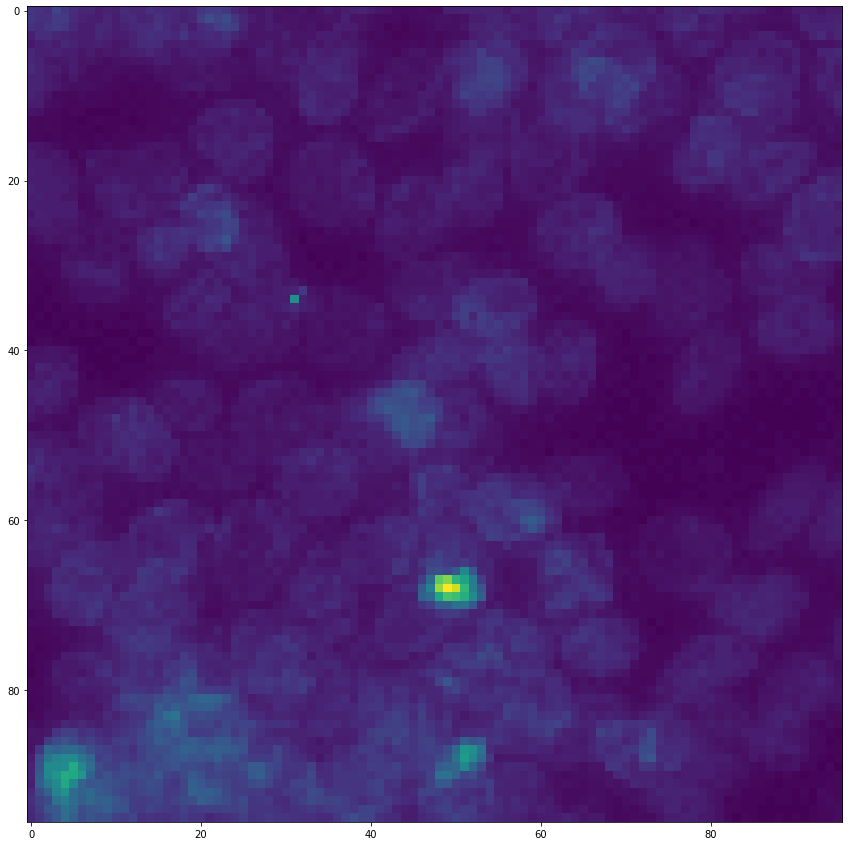

In [17]:

# Creating a Python generator to return a cropped image
def get_random_crop(img):
    # define boundary conditions for x and y coordinate values
    max_x = img.shape[1] - 96
    max_y = img.shape[0] - 96

    # create a range of values and shuffle a random value from there
    x = list(range(max_x))
    np.random.shuffle(x)
    y = list(range(max_y))
    np.random.shuffle(y)

    # for random values of x,y - create cropped images and yield one at a time
    cropped_images = [img[i:i+96, j:j+96] for i in x for j in y]
    for cropped_image in cropped_images:
        yield cropped_image

random_cropped_image = get_random_crop(img)
plt.imshow(next(random_cropped_image))

In [14]:
##Optional Part


import tensorflow as tf

# writing a data generator which would inherit the keras.utils.sequence class
class ImageDataGenerator(tf.keras.utils.Sequence): 
    def __init__(self, img, img_path=None, bounding_box=None, target_size=None, 
                 crop_size=(96, 96), shuffle=True):
        self.img = img
        self.img_path = img_path
        self.bounding_box = bounding_box
        self.target_size = target_size
        self.crop_size = crop_size
        self.max_x = self.img.shape[1] - self.crop_size[1]
        self.max_y = self.img.shape[0] - self.crop_size[0]
        self.shuffle = shuffle
        self.x = list(range(self.max_x))
        self.y = list(range(self.max_y))
        if self.shuffle:
            np.random.shuffle(self.x)
            np.random.shuffle(self.y)

    #The on_epoch_end method is a method that is called after every epoch. We can add routines like shuffling here        
    def on_epoch_end(self):
        # at epoch end, shuffle the indices if shuffle is True
        if self.shuffle:
            np.random.shuffle(self.x)
            np.random.shuffle(self.y)
            
    def __get_input(self):
        # Read the image from path
        if self.img_pth:
            self.img = imread(self.img_pth)
        if self.bounding_box:
            x_min, y_min, width, height = self.bounding_box['x'], self.bounding_box['y'], self.bounding_box['width'], self.bounding_box['height']
            # Get the image according to area specified with bounding box
            self.img = self.img[y_min:y_min+height, x_min:x_min+width]
        # Resize the image to the given target size
        if self.target_size:
            self.img = resize(self.img, self.target_size, anti_aliasing=False)
    
    def __get_data(self):
        # Generates data containing crop_size samples
        cropped_images = [self.img[i:i+self.crop_size[1], j:j+self.crop_size[0]] for i in self.x for j in self.y]
        for cropped_image in cropped_images:
            yield cropped_image
    
    #when the batch corresponding to a given index is called, the generator executes the __getitem__ method to generate it.
    def __getitem__(self):
        # return the x array and 0 value as label
        return next(self.__get_data()), 0
    
    def __len__(self):
        # returns the possible number of images per epoch
        return self.img.size // self.crop_size[0]


# __ it means that you don’t want anyone to override it, it will be accessible only from inside the class where it was defined.

# Additional Implementation for task 3

20.999908
   label     area  equivalent_diameter  ...  solidity  orientation     perimeter
0     10  4516299          2397.984671  ...     0.968     0.714132  48933.963246
1     11        7             2.985411  ...     1.000     1.570796      6.828427
2     12        3             1.954410  ...     1.000    -0.785398      3.414214
3     13        2             1.595769  ...     1.000     0.000000      0.000000
4     14       24             5.527906  ...     0.800    -1.196962     18.071068

[5 rows x 7 columns]


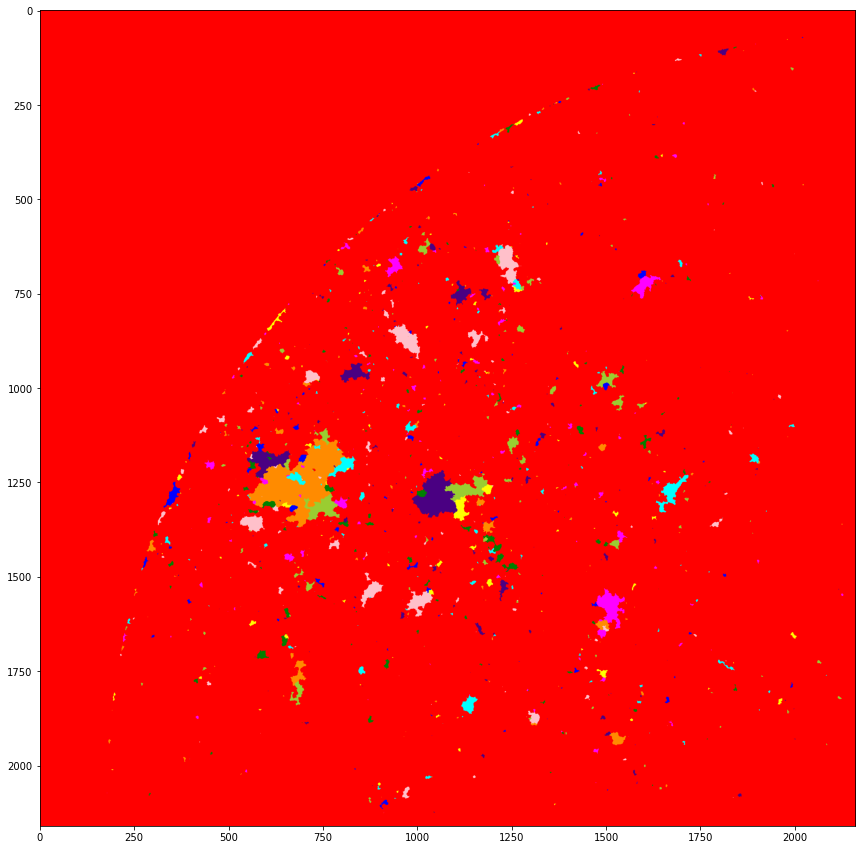

In [15]:
from scipy import ndimage
from skimage import measure, color, io
from skimage.segmentation import watershed

#convert the image into RGB
color_img = cv2.applyColorMap(img, cv2.COLORMAP_JET)
#cv2_imshow(color_img)

#Blue channel. Image equivalent to grey image.
cells=color_img[:,:,0]  


#Threshold image to binary using OTSU. ALl thresholded pixels will be set to 255
ret1, thresh = cv2.threshold(cells, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)


# Morphological operations to remove small noise - opening
#To remove holes we can use closing
kernel = np.ones((3,3),np.uint8)
opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 2)

from skimage.segmentation import clear_border
opening = clear_border(opening) #Remove edge touching grains
#plt.imshow(opening, cmap='gray') #This is our image to be segmented further using watershed



#STEP 1: Sure background 

#To separate touching objects, the best approach would be distance transform and then thresholding.


# dilating pixes a few times increases cell boundary to background. 

sure_bg = cv2.dilate(opening,kernel,iterations=10)
#plt.imshow(sure_bg, cmap='gray') #Dark region is our sure background

# Finding sure foreground area using distance transform and thresholding

#https://www.tutorialspoint.com/opencv/opencv_distance_transformation.htm
dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
#plt.imshow(dist_transform, cmap='gray') #Dist transformed img. 


#Let us threshold the dist transform by starting at 1/2 its max value.
print(dist_transform.max()) 
ret2, sure_fg = cv2.threshold(dist_transform,0.25*dist_transform.max(),255,0)
#plt.imshow(sure_fg, cmap='gray')



# Unknown ambiguous region is nothing but bkground - foreground
sure_fg = np.uint8(sure_fg)  #Convert to uint8 from float
unknown = cv2.subtract(sure_bg,sure_fg)
#plt.imshow(unknown, cmap='gray')

#Now we create a marker and label the regions inside. 

ret3, markers = cv2.connectedComponents(sure_fg)
#plt.imshow(markers)


# add 10 to all labels so that sure background is not 0, but 10
markers = markers+10

# Now, mark the region of unknown with zero
markers[unknown==255] = 0
#plt.imshow(markers, cmap='jet')  

#Now we are ready for watershed filling. 
markers = watershed(cells,markers)


#label2rgb - Return an RGB image where color-coded labels are painted over the image.
img2 = color.label2rgb(markers, bg_label=0)

plt.imshow(img2)


#####################################################################################

#Directly capturing props to pandas dataframe
    
props = measure.regionprops_table(markers, img, 
                          properties=['label',
                                      'area', 'equivalent_diameter',
                                      'mean_intensity', 'solidity', 'orientation',
                                      'perimeter'])

import pandas as pd
dfprop = pd.DataFrame(props)
print(dfprop.head())

